# 1. 异常痫波
通过系统的观察，我们发现0800#于2024-04-18 12:02-12:06时间段内，出现痫波放电，并且从视频、体动和信号的原始波形来看，可初步排除眨眼、心电、运动伪迹。

In [1]:
import os
import dataset
import mne

mne.set_log_level('CRITICAL')

animal = '0800#'
session = '2024-04-18'
raw = mne.io.read_raw_edf(os.path.join(dataset.path['tmp'], animal, session, 'raw.edf'), preload=True)
raw.notch_filter(50)
raw.filter(0.1, 40, picks=[0])
raw.crop(36.5 * 60, 42 * 60)
sf = raw.info['sfreq']
t = raw.times
eeg = raw.get_data(picks=0, units='uV').squeeze()
acg = raw.get_data(picks=1, units='uV').squeeze()

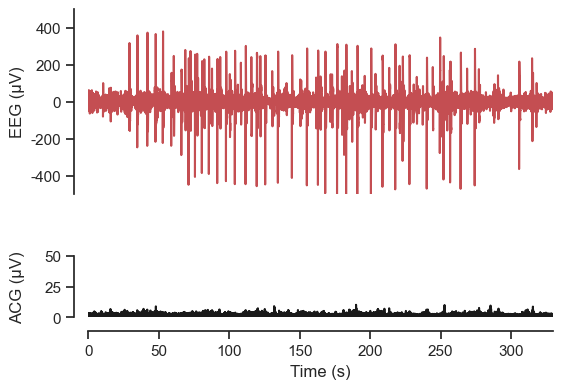

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    context='notebook',
    style='ticks',
    palette='deep',
    font='Arial',
    font_scale=1,
    color_codes=True,
    rc={'axes.unicode_minus': False}
)

fig, ax = plt.subplots(2, 1, figsize=(6, 4),
                       sharex='all', gridspec_kw={'hspace': .5, 'height_ratios': [3, 1]})

sns.lineplot(x=t, y=eeg, ax=ax[0], color='r')
sns.lineplot(x=t, y=acg, ax=ax[1], color='k')

ax[0].set(ylabel='EEG (μV)', ylim=(-500, 500))
ax[0].tick_params("x", length=0)
ax[1].set(ylabel='ACG (μV)', ylim=(0, 50))

plt.xlim(*t[[0, -1]])
plt.xlabel('Time (s)')

sns.despine(offset=10)
sns.despine(ax=ax[0], bottom=True)
fig.align_labels()
plt.show()

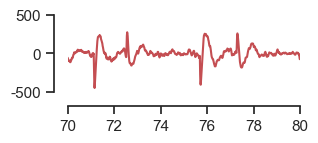

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1))

sns.lineplot(x=t, y=eeg, ax=ax, color='r')

ax.set(ylim=(-500, 500), xlim=(70, 80))
sns.despine(ax=ax, offset=10)


# 2. 使用`find_peak()`进行统计

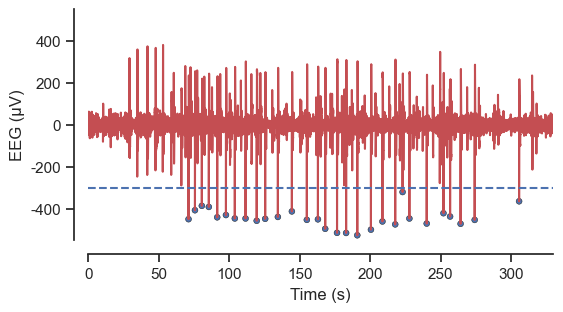

In [4]:
from scipy.signal import find_peaks

peaks, peak_values = find_peaks(-eeg, height=300, prominence=400, width=(0, 0.2 * sf))

sns.set_theme(
    context='notebook',
    style='ticks',
    palette='deep',
    font='Arial',
    font_scale=1,
    color_codes=True,
    rc={'axes.unicode_minus': False}
)

plt.figure(figsize=(6, 3))

sns.lineplot(x=t, y=eeg, color="r")
sns.scatterplot(x=peaks / raw.info['sfreq'], y=eeg[peaks], markers='o', size=3, edgecolor='k')
sns.lineplot(y=-300, x=raw.times[[0, -1]], linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('EEG (μV)')
plt.ylim(-550, 550)
plt.xlim(*t[[0, -1]])
sns.despine(offset=10)
plt.legend().remove()
plt.show()

In [ ]:
import numpy as np

onsets = peaks / sf
durations = np.zeros_like(peaks)
descriptions = ['spike'] * len(onsets)
annot_spike = mne.Annotations(
    onsets, durations, descriptions
)
raw.set_annotations(raw.annotations + annot_spike)

spike_events, event_id = mne.events_from_annotations(raw, event_id={'spike': 1})
epochs = mne.Epochs(raw, spike_events, tmin=-1, tmax=2, event_id=event_id, preload=True)
epochs.plot_image(picks=0, vmin=-300, vmax=300)
plt.show()

# 3. 对多个session进行检查 

先对所有的session制表

In [65]:
import pandas as pd
import glob

files = glob.glob(os.path.join(dataset.path['tmp'], '**', 'raw.edf'), recursive=True)
df_info = dataset.load_info()
df_sessions = pd.DataFrame()

for file in files:
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    group = df_info.loc[animal, 'Genotype']
    
    fname = os.path.join(dataset.path['tmp'], animal, session, 'raw.edf')
    raw = mne.io.read_raw_edf(fname)
    
    # session table
    session_length = raw.times[-1]
    df_sessions_tmp = pd.DataFrame({
        'animal_id': animal,
        'genotype': group,
        'session': session,
        'session_length': session_length
    }, index=[0])
    df_sessions = pd.concat([df_sessions, df_sessions_tmp])    

df_sessions = df_sessions.reset_index(drop=True)    
pd.concat([df_sessions.head(2), df_sessions.tail(2)])

,animal_id,genotype,session,session_length
0,0628#,WT,2024-03-14,2481.996
1,0628#,WT,2024-04-07,4215.996
56,0800#,Mutant,2024-05-14,6162.996
57,0805#,Mutant,2024-03-31,4066.996


## 定义伪迹标准并标注

In [66]:
def find_over_thr_segs(data, thr, pad=0):
    def _find_terminals(bi_data):
        bi_data[0] = 0
        bi_data[-1] = 0
        bi_bad = np.diff(bi_data)
        bad_start_idx = np.argwhere(bi_bad == 1).reshape(-1)
        bad_end_idx = np.argwhere(bi_bad == -1).reshape(-1) + 1 

        return bad_start_idx, bad_end_idx

    flag = np.abs(data) > thr * np.ones(shape=data.shape)
    bi = np.zeros(shape=data.shape)
    bi[flag] = 1

    start_idx, end_idx = _find_terminals(bi)

    if pad > 0:
        start_idx = start_idx - pad
        end_idx = end_idx + pad

        start_idx[start_idx < 0] = 0
        end_idx[end_idx > data.size] = data.size

        bi = np.zeros(shape=data.shape)
        for (start_idx, end_idx) in zip(start_idx, end_idx):
            bi[int(start_idx):int(end_idx)] = 1
            start_idx, end_idx = _find_terminals(bi)

    return start_idx, end_idx, bi

In [67]:
def art_annot(raw): 
    sf = raw.info['sfreq']
    
    # muscle activity
    annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
        raw,
        ch_type='eeg',
        threshold=2,
        min_length_good=0.5,
        filter_freq=[110, 120],
    )

    min_dur_muscle = 0.5    # seconds
    annot_muscle = annot_muscle[annot_muscle.duration > min_dur_muscle]
    
    # acg
    acg = raw.get_data(picks=1, units='uV').squeeze()
    bad_start_idx, bad_end_idx, bi_bad = find_over_thr_segs(acg, thr=20, pad=sf * 2)

    onsets = bad_start_idx / sf
    durations = (bad_end_idx - bad_start_idx) / sf
    descriptions = ['BAD_loco'] * len(bad_start_idx)
    annot_loco = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )
    
    # eeg
    eeg = raw.get_data(picks=0, units='uV').squeeze()
    bad_start_idx, bad_end_idx, bi_bad = find_over_thr_segs(eeg, thr=1200, pad=sf * 2)

    onsets = bad_start_idx / sf
    durations = (bad_end_idx - bad_start_idx) / sf
    descriptions = ['BAD_eeg'] * len(bad_start_idx)
    annot_eeg = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )

    raw.set_annotations(raw.annotations + annot_loco + annot_muscle + annot_eeg)
    
    return raw

In [68]:
def annot_to_mask(raw):
    sf = raw.info['sfreq']
    start_idx = (raw.annotations.onset * sf).astype('int')
    end_idx = ((raw.annotations.onset + raw.annotations.duration) * sf).astype('int')
    flag_ignore = np.zeros_like(raw.times, dtype='bool')
    for (si, ei) in zip(start_idx, end_idx):
        flag_ignore[si:ei+1] = True

    return flag_ignore

In [69]:
def spike_annot(raw, bad_mask):
    sf = raw.info['sfreq']
    
    # spike
    data = raw.copy().filter(0.1, 30).get_data(picks=0, units='uV').squeeze()
    data[bad_mask] = np.nan
    peaks, properties = find_peaks(-data, height=200, prominence=300, distance=0.5 * sf, width=(0, 0.2 * sf))

    onsets = peaks / sf
    durations = np.zeros_like(peaks)
    descriptions = ['spike'] * len(onsets)
    annot_spike = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )
    raw.set_annotations(raw.annotations + annot_spike)
    
    return raw, peaks, properties

In [70]:
animals = df_sessions['animal_id'].unique()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()
    genotype = df_sessions.query('animal_id == @animal')['genotype'].iloc[0]
    
    for session in sessions:
                
        fname = os.path.join(dataset.path['tmp'], animal, session, 'raw.edf')
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        
        raw.set_channel_types({'Loco': 'bio'})
        raw.notch_filter(50)
        
        raw = art_annot(raw)
        raw.export(raw.filenames[0].replace('.edf', '_art_annot.edf'), overwrite=True) 
        

## 对spike进行检测

In [71]:
df_peak_property = pd.DataFrame()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()
    genotype = df_sessions.query('animal_id == @animal')['genotype'].iloc[0] 
    
    for session in sessions:
        
        session_length = df_sessions.query('animal_id == @animal and session==@session')['session_length'].iloc[0]
        
        fname = os.path.join(dataset.path['tmp'], animal, session, 'raw_art_annot.edf')
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        
        bad_mask = annot_to_mask(raw)
        raw, peaks, properties = spike_annot(raw, bad_mask)
        
        raw.export(raw.filenames[0].replace('.edf', '_spike_detect.edf'), overwrite=True)
        
        # spike table
        if peaks.size > 0:
            spike_events, event_id = mne.events_from_annotations(raw, event_id={'spike': 1})
            if spike_events.size > 0:
                epochs = mne.Epochs(raw, spike_events, tmin=-1, tmax=1, event_id=event_id, preload=True)
                if len(epochs) > 0:
    
                    peak_onset = epochs.events[:, 0]
                    isi = np.zeros_like(peak_onset)
                    isi[1:] = np.diff(peak_onset)
    
                    df_peak_property_tmp = pd.DataFrame(properties).loc[epochs.selection, :]
                    df_peak_property_tmp.insert(0, 'isi', isi)
                    df_peak_property_tmp.insert(0, 'peak_onset', peak_onset)
                    df_peak_property_tmp.insert(0, 'session_length', session_length)
                    df_peak_property_tmp.insert(0, 'genotype', genotype)
                    df_peak_property_tmp.insert(0, 'session', session)
                    df_peak_property_tmp.insert(0, 'animal_id', animal)
    
                    df_peak_property = pd.concat([df_peak_property, df_peak_property_tmp])
         
        

In [72]:
def hist_bin(timestamp, bin_width=10, bin_step=5, max_len=None):
    if max_len is None:
        max_len = (timestamp.max() // bin_width) * (bin_width + 1)

    start = 0
    count = []
    start_points = []
    while start < max_len:
        end = start + bin_width
        count.append(((timestamp < end) & (timestamp >= start)).sum())
        start_points.append(start)
        start += bin_step

    return np.array(count) / bin_width, np.array(start_points)

In [73]:
thr_sr = 0.1
bin_width = 30

df_epi_period = pd.DataFrame()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:

        df_spike_session = df_peak_property.query('animal_id == @animal and session == @session')
        df_spike_session = df_spike_session.query('isi / @sf < 10 and isi / @sf > 0')
        df_spike_session = df_spike_session.reset_index(drop=True)

        if len(df_spike_session) > 0:
            session_length = df_spike_session.loc[0, 'session_length']
            
            sr, bin_edges = hist_bin(df_spike_session['peak_onset'] / sf, bin_width=bin_width, bin_step=1,
                                     max_len=session_length)


            onsets, offsets, _ = find_over_thr_segs(sr, thr_sr)
            if len(onsets) > 0:
                # spike rate in onset period
                sr_period = []
                for (on, off) in zip(onsets, offsets):
                    sr_period.append(
                        ((df_spike_session['peak_onset'] / sf < off) & (df_spike_session['peak_onset'] / sf >= on)).sum() / (
                                    off - on))

                # make table of onset period
                df_epi_period_tmp = pd.DataFrame({'onsets': onsets, 'offsets': offsets, 'duration': offsets - onsets})
                df_epi_period_tmp = pd.concat(
                    [pd.concat(
                        [df_sessions.query('animal_id == @animal and session == @session')] * len(df_epi_period_tmp),
                        ignore_index=True), df_epi_period_tmp],
                    axis=1
                )

                df_epi_period_tmp['spike_rate'] = np.array(sr_period)
                df_epi_period = pd.concat([df_epi_period, df_epi_period_tmp])
       
df_epi_period = df_epi_period.reset_index(drop=True)


In [74]:
df_epi_period

,animal_id,genotype,session,session_length,onsets,offsets,duration,spike_rate
0,0629#,Mutant,2024-03-09,2006.996,1936,1956,20,0.100000
1,0767#,Mutant,2024-04-26,5142.996,1465,1479,14,0.142857
2,0800#,Mutant,2024-04-18,3443.996,2240,2294,54,0.148148
3,0800#,Mutant,2024-04-18,3443.996,2294,2302,8,0.125000
4,0800#,Mutant,2024-04-18,3443.996,2304,2310,6,0.166667
5,0800#,Mutant,2024-04-18,3443.996,2341,2373,32,0.156250
6,0800#,Mutant,2024-04-18,3443.996,2377,2381,4,0.250000
7,0800#,Mutant,2024-04-18,3443.996,2383,2399,16,0.125000
8,0800#,Mutant,2024-05-14,6162.996,996,1007,11,0.090909


In [75]:
i = 0
while i < len(df_epi_period) - 1:
    if (
            (df_epi_period.loc[i + 1, 'onsets'] - df_epi_period.loc[i, 'offsets'] <= bin_width) and 
            (df_epi_period.loc[i + 1, 'animal_id'] == df_epi_period.loc[i, 'animal_id']) and 
            (df_epi_period.loc[i + 1, 'session'] == df_epi_period.loc[i, 'session'])
    ):
        spike_counts = (
                df_epi_period.loc[i + 1, 'spike_rate'] * df_epi_period.loc[i + 1, 'duration'] +
                df_epi_period.loc[i, 'spike_rate'] * df_epi_period.loc[i, 'duration']
        ) 
        
        df_epi_period.loc[i, 'offsets'] = df_epi_period.loc[i + 1, 'offsets']
        df_epi_period.loc[i, 'duration'] = df_epi_period.loc[i, 'offsets'] - df_epi_period.loc[i, 'onsets']
        df_epi_period.loc[i, 'spike_rate'] = spike_counts / df_epi_period.loc[i, 'duration']
        df_epi_period = df_epi_period.drop(i + 1)
        df_epi_period = df_epi_period.reset_index(drop=True)
    
    else:
        i += 1

df_epi_period = df_epi_period.query('duration >= @ bin_width')
df_epi_period = df_epi_period.reset_index(drop=True)
df_epi_period.to_excel(os.path.join(dataset.path['results'], 'epi_period.xlsx'))

In [76]:
df_sessions.insert(df_sessions.shape[1], 'spike_rate', 0)
for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:
        df_session_onset = df_epi_period.query("animal_id == @animal and session == @session")
        if len(df_session_onset) == 0:
            spike_rate_session = 0
        else:
            spike_rate_session = (
                (df_session_onset['spike_rate'] * df_session_onset['duration']).sum() / 
                df_session_onset['duration'].sum()
            )
            
        df_sessions.loc[df_sessions.query("animal_id == @animal and session == @session").index, 'spike_rate'] = spike_rate_session

C:\Users\60978\AppData\Local\Temp\ipykernel_35296\2321581495.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.140625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sessions.loc[df_sessions.query("animal_id == @animal and session == @session").index, 'spike_rate'] = spike_rate_session


Text(0, 0.5, 'Spike rate (/s)')

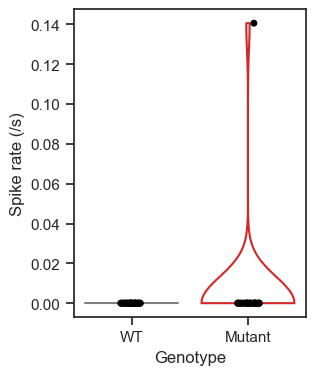

In [77]:
import seaborn as sns

plt.figure(figsize=(3, 4))
sns.violinplot(
    data=df_sessions,
    x='genotype',
    y='spike_rate',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['tab:gray', 'tab:red'],
    cut=0,
    fill=False
)

sns.stripplot(
    data=df_sessions,
    x='genotype',
    y='spike_rate',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['black', 'black']
)
plt.xlabel('Genotype')
plt.ylabel('Spike rate (/s)')

# Sequential slow wave